In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import patsy
import statsmodels.api as sm
from umap import UMAP 
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE


In [3]:
obesity=pd.read_csv('obesity.csv')
obesity.isnull().sum()
obesity.info()
#the data does not have any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [4]:
#first we rename the variable types. 

obesity.rename(columns={'family_history_with_overweight': 'Family_Obesity'}, inplace=True)
obesity.rename(columns={'FAVC': 'High_Calories'}, inplace=True)
obesity.rename(columns={'FCVC': 'Vegetables'}, inplace=True)
obesity.rename(columns={'NCP': 'Meals'}, inplace=True)
obesity.rename(columns={'CAEC': 'Food_Between_Meals'}, inplace=True)
obesity.rename(columns={'SMOKE': 'Smoke'}, inplace=True)
obesity.rename(columns={'CH2O': 'Water'}, inplace=True)
obesity.rename(columns={'SCC': 'Monitor_Calories'}, inplace=True)
obesity.rename(columns={'FAF': 'Excercise'}, inplace=True)
obesity.rename(columns={'TUE': 'Technology'}, inplace=True)
obesity.rename(columns={'CALC': 'Alchohol'}, inplace=True)
obesity.rename(columns={'MTRANS': 'Transportation_Movement'}, inplace=True)


In [4]:
obesity.head()

,Gender,Age,Height,Weight,Family_Obesity,High_Calories,Vegetables,Meals,Food_Between_Meals,Smoke,Water,Monitor_Calories,Excercise,Technology,Alchohol,Transportation_Movement,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
from sklearn.preprocessing import StandardScaler

numerical_columns = ['Age', 'Height', 'Weight', 'Vegetables', 'Meals', 'Water', 'Excercise', 'Technology']
scaler = StandardScaler()
obesity[numerical_columns] = scaler.fit_transform(obesity[numerical_columns])

In [6]:
obesity.head()

,Gender,Age,Height,Weight,Family_Obesity,High_Calories,Vegetables,Meals,Food_Between_Meals,Smoke,Water,Monitor_Calories,Excercise,Technology,Alchohol,Transportation_Movement,NObeyesdad
0,Female,-0.522124,-0.875589,-0.862558,yes,no,-0.785019,0.404153,Sometimes,no,-0.013073,no,-1.188039,0.561997,no,Public_Transportation,Normal_Weight
1,Female,-0.522124,-1.947599,-1.168077,yes,no,1.088342,0.404153,Sometimes,yes,1.618759,yes,2.339750,-1.080625,Sometimes,Public_Transportation,Normal_Weight
2,Male,-0.206889,1.054029,-0.366090,yes,no,-0.785019,0.404153,Sometimes,no,-0.013073,no,1.163820,0.561997,Frequently,Public_Transportation,Normal_Weight
3,Male,0.423582,1.054029,0.015808,no,no,1.088342,0.404153,Sometimes,no,-0.013073,no,1.163820,-1.080625,Frequently,Walking,Overweight_Level_I
4,Male,-0.364507,0.839627,0.122740,no,no,-0.785019,-2.167023,Sometimes,no,-0.013073,no,-1.188039,-1.080625,Sometimes,Public_Transportation,Overweight_Level_II


In [7]:
# Identify the categorical columns to be one-hot encoded
categorical_columns = ['Gender', 'Family_Obesity', 'High_Calories', 'Food_Between_Meals', 'Smoke', 'Monitor_Calories','Alchohol', 'Transportation_Movement']

# Perform one-hot encoding
obesity = pd.get_dummies(obesity, columns=categorical_columns)

# Display the encoded DataFrame
print(obesity.head())

        Age    Height    Weight  Vegetables     Meals     Water  Excercise  \
0 -0.522124 -0.875589 -0.862558   -0.785019  0.404153 -0.013073  -1.188039   
1 -0.522124 -1.947599 -1.168077    1.088342  0.404153  1.618759   2.339750   
2 -0.206889  1.054029 -0.366090   -0.785019  0.404153 -0.013073   1.163820   
3  0.423582  1.054029  0.015808    1.088342  0.404153 -0.013073   1.163820   
4 -0.364507  0.839627  0.122740   -0.785019 -2.167023 -0.013073  -1.188039   

   Technology           NObeyesdad  Gender_Female  ...  Monitor_Calories_yes  \
0    0.561997        Normal_Weight           True  ...                 False   
1   -1.080625        Normal_Weight           True  ...                  True   
2    0.561997        Normal_Weight          False  ...                 False   
3   -1.080625   Overweight_Level_I          False  ...                 False   
4   -1.080625  Overweight_Level_II          False  ...                 False   

   Alchohol_Always  Alchohol_Frequently  Alchohol_

In [8]:
obesity.head()

,Age,Height,Weight,Vegetables,Meals,Water,Excercise,Technology,NObeyesdad,Gender_Female,...,Monitor_Calories_yes,Alchohol_Always,Alchohol_Frequently,Alchohol_Sometimes,Alchohol_no,Transportation_Movement_Automobile,Transportation_Movement_Bike,Transportation_Movement_Motorbike,Transportation_Movement_Public_Transportation,Transportation_Movement_Walking
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,Normal_Weight,True,...,False,False,False,False,True,False,False,False,True,False
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,Normal_Weight,True,...,True,False,False,True,False,False,False,False,True,False
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,Normal_Weight,False,...,False,False,True,False,False,False,False,False,True,False
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,Overweight_Level_I,False,...,False,False,True,False,False,False,False,False,False,True
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,Overweight_Level_II,False,...,False,False,False,True,False,False,False,False,True,False


In [9]:
# obesity_labels = obesity.columns.tolist()
obesity_labels = obesity['NObeyesdad']
obesity = obesity.drop('NObeyesdad', axis=1)
print(obesity_labels)

0             Normal_Weight
1             Normal_Weight
2             Normal_Weight
3        Overweight_Level_I
4       Overweight_Level_II
               ...         
2106       Obesity_Type_III
2107       Obesity_Type_III
2108       Obesity_Type_III
2109       Obesity_Type_III
2110       Obesity_Type_III
Name: NObeyesdad, Length: 2111, dtype: object


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = obesity.iloc[:, :-1]
y = obesity.iloc[:, -1]
 
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)


In [11]:
# Preview of the training dataset
X_train

,Age,Height,Weight,Vegetables,Meals,Water,Excercise,Technology,Gender_Female,Gender_Male,...,Monitor_Calories_no,Monitor_Calories_yes,Alchohol_Always,Alchohol_Frequently,Alchohol_Sometimes,Alchohol_no,Transportation_Movement_Automobile,Transportation_Movement_Bike,Transportation_Movement_Motorbike,Transportation_Movement_Public_Transportation
1295,2.180837,-1.542294,-0.264440,-0.785019,0.404153,-1.196520,-1.188039,-1.080625,True,False,...,True,False,False,False,True,False,True,False,False,False
1627,2.530338,0.222106,0.869314,-0.256800,1.394543,-1.644905,0.376558,-1.080625,False,True,...,True,False,False,False,False,True,True,False,False,False
1388,2.417280,-1.381675,-0.248216,-0.650845,0.375753,-0.880723,-1.188039,-1.080625,True,False,...,True,False,False,False,False,True,True,False,False,False
1318,-0.169486,0.636030,0.429379,-0.785019,0.404153,1.600435,1.669380,2.168551,False,True,...,True,False,False,False,False,True,False,False,False,True
648,-0.278243,0.222803,-1.325371,0.457808,0.404153,-1.577820,-0.253878,1.205819,True,False,...,True,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,-0.731460,-0.023620,-0.327900,-0.925401,-0.420811,1.250035,-1.188039,-0.861226,False,True,...,True,False,False,False,False,True,False,False,False,True
1731,0.983906,0.830364,1.299023,0.472452,0.404153,0.224143,-0.150035,-0.105044,False,True,...,True,False,False,False,True,False,True,False,False,False
763,-0.522124,-0.875589,-0.633419,-0.785019,-2.167023,1.618759,-0.012109,-1.080625,False,True,...,True,False,False,False,True,False,False,False,False,True
835,0.789315,-0.634323,-0.636982,-0.097591,0.404153,-0.132887,0.671390,-1.080625,True,False,...,True,False,False,False,True,False,True,False,False,False


## Visualization using PCA, UMAP, and tSNE
Running UMAP might take 2-5 minutes. Run the plots at your discretion but otherwise assume the findings below are relatively accurate.

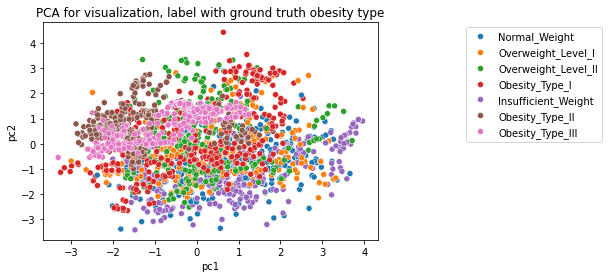

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

# call fit_transform on pca
pcs = pca.fit_transform(obesity)

# transform it into data frame
pcs = pd.DataFrame(pcs,columns=['pc1','pc2'])
pcs.index = obesity.index
# plot the components
pcs['obesity_type'] = obesity_labels

sns.scatterplot(data=pcs, x='pc1', y='pc2', hue='obesity_type')
plt.title('PCA for visualization, label with ground truth obesity type')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1));

PCA gives us a nice overview of what's happening, although there is significant overlap between the different types of obesity. Let's keep experimenting with UMAP and observe our results.

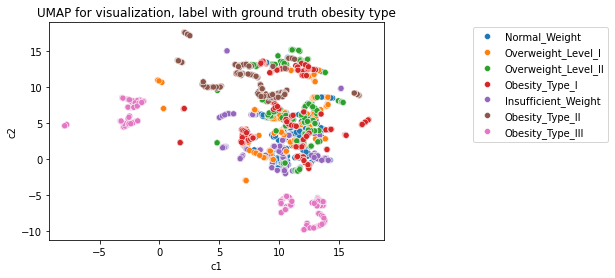

In [12]:
viz = UMAP(n_neighbors=5, min_dist=0.1)
viz_coords = pd.DataFrame(viz.fit_transform(obesity), columns=['c1', 'c2'])
viz_coords['obesity_type'] = obesity_labels

sns.scatterplot(data=viz_coords, x='c1', y='c2', hue='obesity_type')
plt.title('UMAP for visualization, label with ground truth obesity type')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1));

Here's an output for umap n_neighbors = 5  for reference
![title](images/umap-5.jpeg)

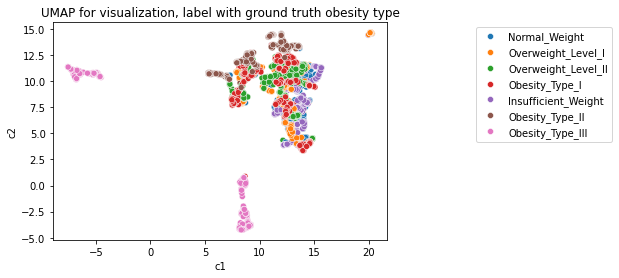

In [13]:
viz = UMAP(n_neighbors=20, min_dist=0.1)
viz_coords = pd.DataFrame(viz.fit_transform(obesity), columns=['c1', 'c2'])
viz_coords['obesity_type'] = obesity_labels

sns.scatterplot(data=viz_coords, x='c1', y='c2', hue='obesity_type')
plt.title('UMAP for visualization, label with ground truth obesity type')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1));

Here's an output for umap n_neighbors = 20  for reference
![title](images/umap-20.jpeg)

## UMAP results
We sampled just two values of n_neighbors due to the sake of scope and computational complexity, but we can see that the data is tightly centered with little coherence in both cases. Obesity_Type_III appears to have a distinct separability from the rest of the labels, generally with a high degree of covariance. Let's try tSNE to see if we can get a a better picture of the data

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb599672c10>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


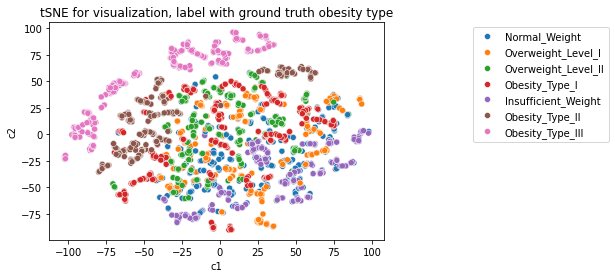

In [14]:
tsne_perp_5 = TSNE(n_components = 2, perplexity = 5, random_state = 99)
tcs = tsne_perp_5.fit_transform(obesity)
# construct the data frame
tcs = pd.DataFrame(tcs,columns=['c1','c2'])
tcs.index = obesity.index

tcs['obesity_type'] = obesity_labels

sns.scatterplot(data=tcs, x='c1', y='c2', hue='obesity_type')
plt.title('tSNE for visualization, label with ground truth obesity type')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1));



Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb4ed3119d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


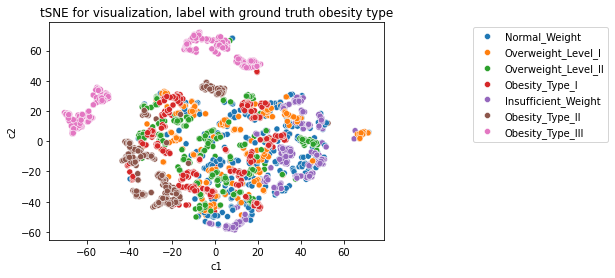

In [75]:
tsne_perp_5 = TSNE(n_components = 2, perplexity = 20, random_state = 99)
tcs = tsne_perp_5.fit_transform(obesity)
# construct the data frame
tcs = pd.DataFrame(tcs,columns=['c1','c2'])
tcs.index = obesity.index

tcs['obesity_type'] = obesity_labels

sns.scatterplot(data=tcs, x='c1', y='c2', hue='obesity_type')
plt.title('tSNE for visualization, label with ground truth obesity type')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1));



## tSNE Results
tSNE captures the local relationships so we do we see somewhat better results however at least in 2 dimensions, the data doesn't seem to adhere to the assumptions of classical models like KMeans nor GMM. Something like DBSCAN or Hierarchical clustering might offer a solution. We can try running KMeans as a baseline measure. Before moving on, we should first decide on an optimal perplexity parameter going forward to maintain consistent plots. We'll fine tune it  using the KL divergence as a performance metric

In [59]:
perplexities= [2, 5, 10, 20, 40, 80, 100, 200, 400]
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
# Define range of perplexity values
REPS = 10  # Number of random starts

# Initialize arrays to store results
costs = []
all_perplexities = []

# Perform t-SNE for each perplexity value
for perplexity in perplexities:
        # Uses barnes hut approximation to speed up process
        tsne = TSNE(n_components=2, perplexity=perplexity, method='barnes_hut', n_iter=1000, random_state=99)
        embedded_data = tsne.fit_transform(obesity)

        # Compute KL divergence
        kl_divergence = tsne.kl_divergence_

        # Store KL divergence and perplexity
        costs.append(kl_divergence)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb50d3285e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb4ed56f160>
Traceback 

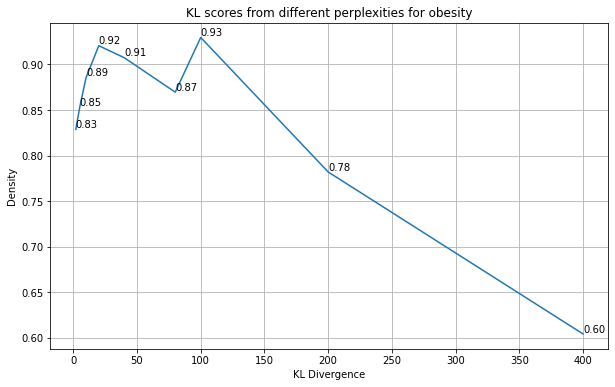

In [66]:
plt.figure(figsize=(10, 6))  # Set width to 10 inches and height to 6 inches

plt.plot(perplexities, costs)

plt.title('KL scores from different perplexities for obesity')
plt.xlabel('KL Divergence')
plt.ylabel('Density')  # Add ylabel for the y-axis

for i, (perplexity, cost) in enumerate(zip(perplexities, costs)):
    plt.text(perplexity, cost, f'{cost:.2f}', verticalalignment='bottom')

plt.grid()
plt.show()

We can see that a perplexity value of 100, gives us the best KL divergence score but 20 does as good a job. To keep things simple, we'll stick with 20.